# Exploring the DC3 dataset

Explore the DC3 dataset to extract physical quantities which were not explicitely calculated. The dataset was used for training ML model for structural recognition. We have made the annotated set which includes information not just about the structure, but also about the simulation method (MD), including temperature, potential.

Start with imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pychromatic import Multiplot
import matplotlib
from atomrdf import System, KnowledgeGraph

Unarchive the dataset. Can be done with either a tar archive or simply a folder.

In [2]:
#kg = KnowledgeGraph.unarchive('DC3_dataset_00.tar.gz')
kg = KnowledgeGraph.unarchive('DC3_dataset_00', compress=False)

In [3]:
kg.n_samples

2339

There are more than 2000 MD snapshots in this dataset. We choose an element, and query the relevant data.

In [4]:
element = 'Al'

In [5]:
condition = (kg.terms.cmso.hasChemicalSymbol==element) & (kg.terms.cmso.hasElementRatio==1.0) & (kg.terms.rdfs.label@kg.terms.asmo.InputParameter=='temperature') & (kg.terms.rdfs.label@kg.terms.cmso.CalculatedProperty=='Volume')

In [1]:
condition = (kg.terms.cmso.hasChemicalSymbol==element) & \
            (kg.terms.cmso.hasElementRatio==1.0) & \
            (kg.terms.rdfs.label@kg.terms.asmo.InputParameter=='temperature') & \
            (kg.terms.rdfs.label@kg.terms.cmso.CalculatedProperty=='Volume')

kg.auto_query(kg.terms.cmso.AtomicScaleSample, 
             [condition,
              kg.terms.cmso.hasReference@kg.terms.asmo.hasInteratomicPotential, 
              kg.terms.asmo.hasValue@kg.terms.asmo.InputParameter,
              kg.terms.asmo.hasValue@kg.terms.cmso.CalculatedProperty,]
             )

NameError: name 'kg' is not defined

In [6]:
q = kg.auto_query(kg.terms.cmso.AtomicScaleSample, 
                  [condition,
                   kg.terms.cmso.hasReference@kg.terms.asmo.hasInteratomicPotential, 
                   kg.terms.asmo.hasValue@kg.terms.asmo.InputParameter,
                  kg.terms.asmo.hasValue@kg.terms.cmso.CalculatedProperty,], return_query=True)
q

'PREFIX cmso: <http://purls.helmholtz-metadaten.de/cmso/>\nPREFIX qudt: <http://qudt.org/schema/qudt/>\nPREFIX pldo: <http://purls.helmholtz-metadaten.de/pldo/>\nPREFIX podo: <http://purls.helmholtz-metadaten.de/podo/>\nPREFIX asmo: <http://purls.helmholtz-metadaten.de/asmo/>\nPREFIX ns: <http://www.w3.org/ns/>\nPREFIX calculation: <https://w3id.org/mdo/calculation/>\nPREFIX ldo: <http://purls.helmholtz-metadaten.de/cdos/ldo/>\nPREFIX prov: <http://www.w3.org/ns/prov#>\nPREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\nPREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>\nSELECT DISTINCT ?AtomicScaleSample ?hasChemicalSymbolvalue ?hasInteratomicPotential_hasReferencevalue ?InputParameter_hasValuevalue ?CalculatedProperty_hasValuevalue ?hasElementRatiovalue ?InputParameter_labelvalue ?CalculatedProperty_labelvalue\nWHERE {\n    ?AtomicScaleSample cmso:hasSpecies ?cmso_Atom .\n    ?cmso_Atom cmso:hasElement ?cmso_ChemicalElement .\n    ?cmso_ChemicalElement cmso:hasChemicalSymbo

In [7]:
print(q)

PREFIX cmso: <http://purls.helmholtz-metadaten.de/cmso/>
PREFIX qudt: <http://qudt.org/schema/qudt/>
PREFIX pldo: <http://purls.helmholtz-metadaten.de/pldo/>
PREFIX podo: <http://purls.helmholtz-metadaten.de/podo/>
PREFIX asmo: <http://purls.helmholtz-metadaten.de/asmo/>
PREFIX ns: <http://www.w3.org/ns/>
PREFIX calculation: <https://w3id.org/mdo/calculation/>
PREFIX ldo: <http://purls.helmholtz-metadaten.de/cdos/ldo/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
SELECT DISTINCT ?AtomicScaleSample ?hasChemicalSymbolvalue ?hasInteratomicPotential_hasReferencevalue ?InputParameter_hasValuevalue ?CalculatedProperty_hasValuevalue ?hasElementRatiovalue ?InputParameter_labelvalue ?CalculatedProperty_labelvalue
WHERE {
    ?AtomicScaleSample cmso:hasSpecies ?cmso_Atom .
    ?cmso_Atom cmso:hasElement ?cmso_ChemicalElement .
    ?cmso_ChemicalElement cmso:hasChemicalSymbol ?hasChemicalSy

Sort by temperature

In [7]:
q = q.sort_values('InputParameter_hasValuevalue')

Extract the relevant values into a numpy array

In [8]:
temps = np.array([x.toPython() for x in q.InputParameter_hasValuevalue.values])
volumes = np.array([x.toPython() for x in q.CalculatedProperty_hasValuevalue.values])

In [9]:
temps, indices = np.unique(temps, return_index=True)
volumes = volumes[indices]

Plot the results

Text(0, 0.5, 'Volume ($\\AA^3$/atom)')

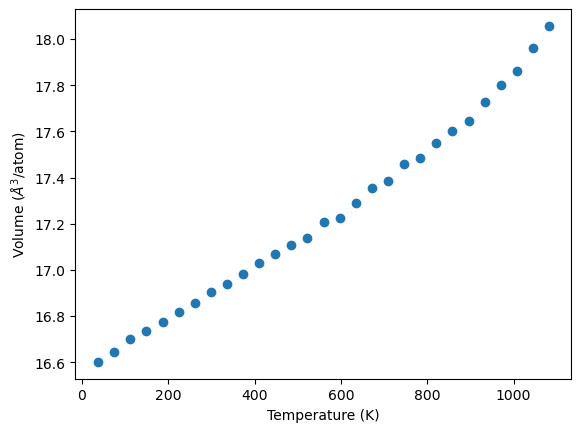

In [10]:
plt.plot(temps, volumes, 'o')
plt.xlabel('Temperature (K)')
plt.ylabel('Volume ($\AA^3$/atom)')

Calculate the coefficient of volumetric thermal expansion around 273 K,

$$
\alpha = \frac{1}{V} \frac{\partial V}{\partial T}
$$

In [11]:
anchor_arg = np.argsort(np.abs(temps-273))[0]
mind = anchor_arg-3
maxd = anchor_arg+3
fit = np.polyfit(temps[mind:maxd], volumes[mind:maxd], 1)
(1/volumes[mind])*fit[0]

6.599158944090497e-05

Create a function to find for all elements in the dataset

In [58]:
def calculate_alpha(element, kg, res_dict, anchor_temp=293):
    condition = (kg.terms.cmso.hasChemicalSymbol==element) & (kg.terms.cmso.hasElementRatio==1.0) & (kg.terms.rdfs.label@kg.terms.asmo.InputParameter=='temperature') & (kg.terms.rdfs.label@kg.terms.cmso.CalculatedProperty=='Volume')
    q = kg.auto_query(kg.terms.cmso.AtomicScaleSample, 
                  [condition,
                   kg.terms.cmso.hasReference@kg.terms.asmo.hasInteratomicPotential, 
                   kg.terms.asmo.hasValue@kg.terms.asmo.InputParameter,
                  kg.terms.asmo.hasValue@kg.terms.cmso.CalculatedProperty,])
    q = q.sort_values('InputParameter_hasValuevalue')
    temps = np.array([x.toPython() for x in q.InputParameter_hasValuevalue.values])
    volumes = np.array([x.toPython() for x in q.CalculatedProperty_hasValuevalue.values])
    temps, indices = np.unique(temps, return_index=True)
    volumes = volumes[indices]
    anchor_arg = np.argsort(np.abs(temps-anchor_temp))[0]
    mind = anchor_arg-3
    maxd = anchor_arg+3
    fit = np.polyfit(temps[mind:maxd], volumes[mind:maxd], 1)
    alpha = (1/volumes[mind])*fit[0]
    res_dict[element] = {}
    res_dict[element]['temp'] = temps
    res_dict[element]['vol'] = volumes
    res_dict[element]['alpha'] = alpha

Check which elements are present in kg

In [59]:
q = kg.auto_query(kg.terms.cmso.AtomicScaleSample, [kg.terms.cmso.hasChemicalSymbol, kg.terms.cmso.hasElementRatio])
q

,AtomicScaleSample,hasChemicalSymbolvalue,hasElementRatiovalue
0,sample:000bdae3-cf92-44c2-a661-b68a2d21b3b5,Li,1.0
1,sample:002119b1-92b0-400e-84d9-58b83cab698d,Li,1.0
2,sample:00676a80-80e0-4fc6-9fab-086db0a92495,Al,1.0
3,sample:00921fa1-6ea1-4e35-b6b6-e843bf367f47,Ti,1.0
4,sample:009895bf-d7aa-4df2-acd7-7599a35503cc,Mg,1.0
...,...,...,...
2334,sample:ff42583d-ff7e-4ab4-af02-aa58b2d3fc08,Ge,1.0
2335,sample:ff73c664-610a-4feb-b06b-245ed2fcea6c,Ti,1.0
2336,sample:ff9f1f95-a59e-4901-b72f-694c50952194,Si,1.0
2337,sample:ffb4543c-5b79-4ce1-9efb-653d340c29cb,Ge,1.0


In [60]:
symbols = np.array(q.hasChemicalSymbolvalue.values)
ratios = np.array(q.hasElementRatiovalue.values)

#take only pure elements
symbols = [symbols[count].toPython() for count, x in enumerate(ratios) if x.toPython()==1]
symbols = np.unique(symbols)
symbols

array(['Al', 'Ar', 'Fe', 'Ge', 'Li', 'Mg', 'Si', 'Ti'], dtype='<U2')

We filter a list of metals

In [66]:
symbols = ['Al', 'Fe', 'Mg', 'Ti']

In [67]:
res_dict = {}
for symbol in symbols:
    calculate_alpha(symbol, kg, res_dict)

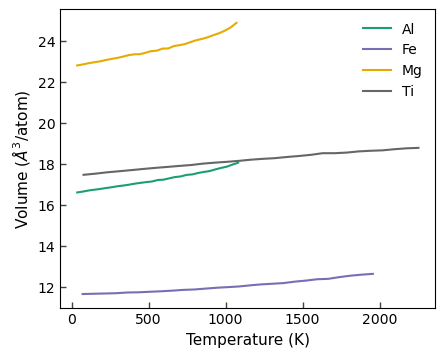

In [68]:
cmap = matplotlib.colormaps['Dark2']
colors = np.linspace(0, 1, len(res_dict))

mlt = Multiplot(width=350, ratio=0.8)
count = 0
for key, val in res_dict.items():
    mlt[0,0].plot(val['temp'], val['vol'], label=key, color=cmap(colors[count]))
    count += 1
mlt[0,0].legend(frameon=False)
mlt[0,0].set_xlabel('Temperature (K)', fontsize=11)
mlt[0,0].set_ylabel('Volume ($\AA^3$/atom)', fontsize=11)
plt.savefig('thermal_expansion.png', dpi=300, bbox_inches='tight')

In [69]:
for key, val in res_dict.items():
    print(key, val['alpha'])

Al 6.626092529857431e-05
Fe 2.095294054009922e-05
Mg 6.897171999379069e-05
Ti 4.2246331402419025e-05


Generate latex table

In [70]:
print('\\begin{table}[]')
print('\\begin{tabular}{ll}')
print('Element & Alpha \\\\')
for key, val in res_dict.items():
    print(f'{key} & {np.round(val["alpha"]*1e6, decimals=2)} \\\\')
print('\end{tabular}')
print('\caption{}')
print('\label{undefined}')
print('\end{table}')

\begin{table}[]
\begin{tabular}{ll}
Element & Alpha \\
Al & 66.26 \\
Fe & 20.95 \\
Mg & 68.97 \\
Ti & 42.25 \\
\end{tabular}
\caption{}
\label{undefined}
\end{table}
